In [1]:
import sys
sys.path.append("/home/emastr/moment-constrained-cryo-em/src/")

from single_degree_alignment import *
from geometry import *
from single_degree_plot import *

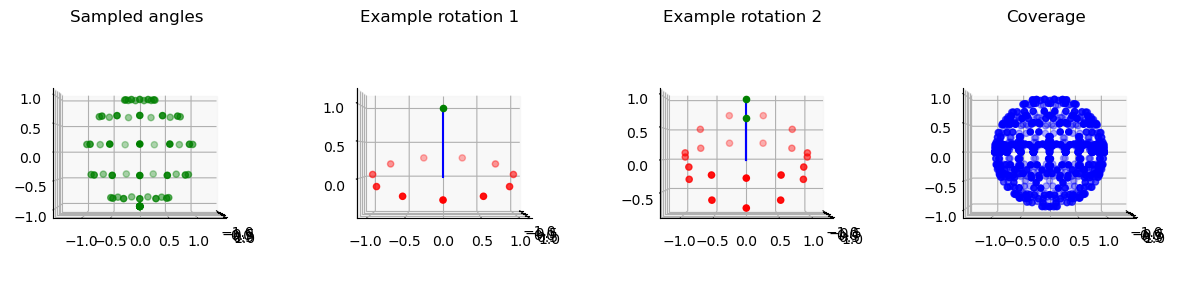

In [5]:
base_key = jax.random.PRNGKey(1)

# Indices
Lmax = 5
ms, ls = get_l_and_m(Lmax)
eval_shell_wrap = lambda thetas, phis, fm: eval_shell(thetas, phis, fm, ls, ms, Lmax)

# Interpolation grid
sampling_interp = "mw"
phis = s2fft.sampling.s2_samples.phis_equiang(Lmax+1, sampling_interp)
thetas = s2fft.sampling.s2_samples.thetas(Lmax+1, sampling_interp)
phis_grid, thetas_grid = jnp.meshgrid(phis, thetas, indexing="ij")

# Random signal
base_key, key = jax.random.split(base_key)
fm = random_signal(Lmax, key)
f = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, Lmax), (0, None)), (None, 0))(thetas, phis)

# Reference grid
Alphas = phis_grid.flatten()
Betas = thetas_grid.flatten()
Gammas = jnp.zeros_like(Alphas)
d_betas, sph_zero = get_slicing_weights(Betas, ms, Lmax)
fm_rot_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas, d_betas, Gammas, ms, sph_zero)


# Random rotations
Nrots = 300
rnd_idx = jax.random.randint(key, (Nrots,), 0, len(Alphas))
Alphas_data = Alphas[rnd_idx]
Betas_data = Betas[rnd_idx]
Gammas_data = jax.random.uniform(key, (Nrots,))*2*jnp.pi
d_betas_data, sph_zero = get_slicing_weights(Betas_data, ms, Lmax)
fm_rot_slices_data = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas_data, d_betas_data, Gammas_data, ms, sph_zero)
f_rot_slices_data = vmap(ifft_shifted)(fm_rot_slices_data)

plot_rot(Alphas, Betas, Gammas, (2*Lmax+1))

In [14]:
#f_rot_slices_est = align_data_to_slices_average(fm_rot_slices, f_rot_slices_data, fm_rot_slices_data)

vmap_aligns = vmap(align_data_to_slices, (None, 0, 0))
data, fft_data = f_rot_slices_data, fm_rot_slices_data
aligned_data, slice_idx = vmap_aligns(fm_rot_slices, data, fft_data)

conditional_mean = lambda idx: jnp.sum(jnp.where(slice_idx[:, None] == idx, aligned_data, jnp.zeros_like(aligned_data)), axis=0)/jnp.sum(slice_idx == idx)
f_rot_slices_est = vmap(conditional_mean)(jnp.arange(fm_rot_slices.shape[0]))
fm_rot_slices_est = vmap(fft_shifted)(f_rot_slices_est)

print(slice_idx)

[43 12 59  0 58 16 51 54 54  3 19 64 25 23 62 26  3 24 49 51 49 35 58 39
 61 35 30  6 38 63 15 42 19 34 25 40 53 11 58 42 38 16 52  2 18 34 28 46
 22 46 60 15 62 55 31 43 50 61 21  3  0 30 52 34 61  6 13 60 63 61  1 43
 62 36 40 30 27 56 56 13 38 13  6 43 25 45 45 43 24 16 65 24 23  3 40 45
 65  0 15 40  6  7 44 44 62 28 32 22 33 47 23 20 64  9 11 46 21 31 34 54
 39 35 55 31 22 35 63 11 57 56 29 50 63 51 16 63 65 57 18 55 27 10 48 50
 30 34  6 29 43 65 20 20  2 41  7 13 45  1 47 59 39 59 36 45 48 52 51 34
 23 54 14  5 63 54 58 50 44 39 57 47 43 35 46 11 65 53  0 49  8 58 30 59
 55 64 16 23 51  2 23 46 29 41 61 42 16 30 28 45 39 13 23 18  3  0 64 19
 25 16  3 45 55 42 20 29 44 12 40 57 56 24 58  6 43 54 28 15 10  5  8 55
 19 17 31 39  7 57 13 36 39 50 20 16 65 13 52  6 20 48 37 26 11 26  6 17
 32 53 31 45 42 40 35 10 50  4 47 32 44 35 48 19 37  8  8 16 42 47 10 58
 61 56 12 31 58  2 62 12 30 40  4 61]


(66, 11)


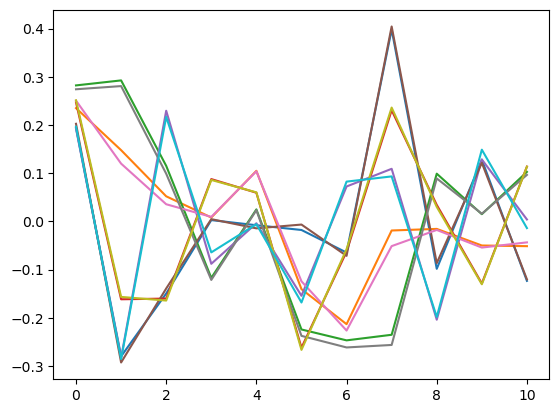

In [12]:
print(f_rot_slices_est.shape)
for fi in f_rot_slices_est[0:5]:
    plt.plot(fi)
for fi in vmap(ifft_shifted)(fm_rot_slices)[0:5]:
    plt.plot(fi)